Lower layer has QBCM+weight decay. Upper layer is a linear layer to learn reconstruction, and updated using gradient descent on L2 loss (do not back-propagate to lower layer). Trained on MNIST dataset, pre-centered at zero-mean, mini-batch size 100. Trained with a bottleneck dimension 40 (input dimension 784)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import matplotlib.pyplot as plt
from local_lr import QBCM_tf
from local_lr import data_loader

% matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('\tmp\data')

Extracting 	mp\data/train-images-idx3-ubyte.gz
Extracting 	mp\data/train-labels-idx1-ubyte.gz
Extracting 	mp\data/t10k-images-idx3-ubyte.gz
Extracting 	mp\data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train = mnist.train.images
X_train = X_train[:1000,:]
X_label = mnist.train.labels[:1000]

from sklearn.preprocessing import StandardScaler

demeaner = StandardScaler(with_std=False)
X_train_demean = demeaner.fit_transform(X_train)

zcamatrix = data_loader.zca_whitening_matrix(X_train_demean.T)
X_train_whiten = X_train.dot(zcamatrix)

In [54]:
# Use tensorflow to train one layer fully connected network with objective function 
# of QBCM, relu activation and l2 regularizaiton

# Give the training parameter
learning_rate = 0.0001
epochs = 1000

# Build the network
n_input = 784
n_output = 40

X = tf.placeholder(tf.float32, shape=(None, n_input), name='X')

# Initializet he variable
initializer = tf.contrib.layers.variance_scaling_initializer()

w_init = initializer([n_input, n_output])

w = tf.Variable(w_init, tf.float32, name='weights')

output = tf.matmul(tf.transpose(X), w)

# Define the loss function
loss = QBCM_tf.QBCM_obj(X, w)

# Choose the training algorithm
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
trainer = optimizer.minimize(loss)

init = tf.global_variables_initializer()
# Define the training operation
with tf.Session() as sess:
    init.run()
    
    weights_track = []
    for i in range(epochs):    # Objective function training needs to use all the available data
        trainer.run(feed_dict={X:X_train_demean})
        weights = w.eval()
        weights_track.append(weights)

In [55]:
weights_show = weights_track[380]
weights_show = weights

In [6]:
weights_show = np.load('QBCM_obj_55000_stochastic_epcoh1000.npy')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


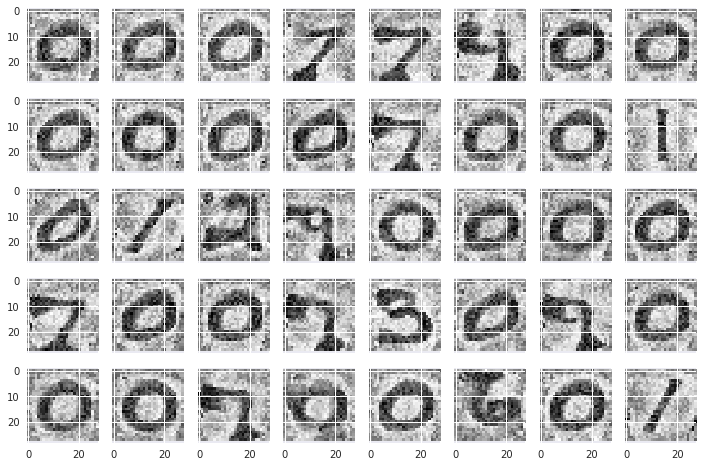

In [7]:
n_row = 5
n_col = 8

fig, axes = plt.subplots(n_row,n_col,sharex=True, sharey=True)
fig.set_figwidth(12)
fig.set_figheight(8)

for i in range(n_row):
    for j in range(n_col):
        axes[i][j].imshow(weights_show[:,i * n_col + j].reshape(28,28), cmap="Greys")

In [57]:
weights.shape

(784, 40)

In [58]:
# np.save('QBCM_obj_55000_stochastic_epcoh1000', weights)

In [ ]:
data = X_train_demean
dim_x = data.shape[1]
n_output = 40
eta = 0.0005
decay = 0.01
p = 2
tau = 200
epoch=1
sample_size = data.shape[0]

# Give input place holder
input_value = tf.placeholder(tf.float32, [1, dim_x])
obj_input = tf.placeholder(tf.float32, [sample_size, dim_x])

# Varaible
w = tf.Variable(tf.random_normal([dim_x, n_output]))
threshold = tf.Variable(tf.zeros([1, n_output]))

### Computation steps
# Compute output with ReLU
net_input = tf.matmul(input_value, w)
output_value = tf.nn.relu(net_input)

# Update weights with QBCM learning rule
out_thre_diff = output_value - threshold
delta_w = eta * tf.matmul(input_value, tf.multiply(output_value, out_thre_diff), transpose_a = True)- eta * decay * w
new_w = w + delta_w
update_w = tf.assign(w, new_w)

# Update threshold
h = tf.exp(-1/tau)
new_thres = threshold * h + tf.pow(output_value, p) * (1 - h)
update_thres = tf.assign(threshold, new_thres)

# Calculate QBCM objective function
obj_net_input = tf.matmul(obj_input, w)
obj_output = tf.nn.relu(obj_net_input)
obj1 = tf.reduce_mean(tf.pow(obj_output, 3))
obj2 = tf.reduce_mean(tf.pow(obj_output, 2))
obj = obj1/3 - tf.pow(obj2, 2)/4

# Train the model
epoch = 40

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

w_track = []
y_track = []
thres_track = []
for i in range(epoch):
    tf.random_shuffle(data)
    for j in range(data.shape[0]):
        sess.run(update_w, feed_dict = {input_value: data[j,:].reshape(1,data.shape[1])})
        sess.run(update_thres, feed_dict = {input_value: data[j,:].reshape(1,data.shape[1])})
        sess.run(obj, feed_dict = {obj_input: data})
        w_track.append(sess.run(w))
        thres_track.append(sess.run(threshold))

In [ ]:
# Use tensorflow to train one layer fully connected network with objective function 
# of QBCM, relu activation and l2 regularizaiton

In [ ]:
# Build the network
n_input = 784
n_hidden1 = 40
n_output = 784

learning_rate = 0.0001
activation =tf.nn.relu
initializer = tf.contrib.layers.variance_scaling_initializer()

X=tf.placeholder(tf.float32, shape=(None, n_inputs))

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_output])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')

hidden1 = activation(tf.matmul(X, weights1))
outputs = tf.matmul(hidden1, weights2)

optimizer = tf.train.AdamOptimizer(learning_rate)

# Train lower layer with QBCM rule
with tf.name_scope("phase1"):
    phase1_output = hidden1
    
    